In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, mixed_precision
from tensorflow.keras.applications import VGG16
import os
import random
from PIL import Image
from tqdm import tqdm

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

def load_and_process_image(image_path, target_size=(256, 256)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size, Image.LANCZOS)
    image = np.array(image, dtype=np.float32) / 127.5 - 1  # Normalize to [-1, 1]
    return image

def find_corresponding_color_image(gray_image_name):
    return gray_image_name.replace('_s1_', '_s2_')

@tf.function
def load_images_from_path(gray_path, color_path):
    gray_image = tf.io.read_file(gray_path)
    gray_image = tf.image.decode_png(gray_image, channels=3)
    gray_image = tf.image.resize(gray_image, (256, 256))
    gray_image = tf.cast(gray_image, tf.float32) / 127.5 - 1

    color_image = tf.io.read_file(color_path)
    color_image = tf.image.decode_png(color_image, channels=3)
    color_image = tf.image.resize(color_image, (256, 256))
    color_image = tf.cast(color_image, tf.float32) / 127.5 - 1

    return gray_image, color_image

def create_dataset(base_dirs, max_images_per_folder=500, batch_size=8):
    gray_paths = []
    color_paths = []

    for base_dir in base_dirs:
        s1_path = os.path.join(base_dir, 's1')
        s2_path = os.path.join(base_dir, 's2')

        if not os.path.isdir(s1_path) or not os.path.isdir(s2_path):
            print(f"Missing directories: {s1_path} or {s2_path}")
            continue

        gray_image_files = [f for f in os.listdir(s1_path) if f.endswith('.png')]
        random.shuffle(gray_image_files)
        gray_image_files = gray_image_files[:max_images_per_folder]

        for file_name in gray_image_files:
            gray_image_path = os.path.join(s1_path, file_name)
            color_image_name = find_corresponding_color_image(file_name)
            color_image_path = os.path.join(s2_path, color_image_name)

            if os.path.isfile(color_image_path):
                gray_paths.append(gray_image_path)
                color_paths.append(color_image_path)
            else:
                print(f"No corresponding color image found for {file_name}")

    dataset = tf.data.Dataset.from_tensor_slices((gray_paths, color_paths))
    dataset = dataset.map(load_images_from_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size=len(gray_paths)).batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
def attention_gate(x, g, inter_channel):
    theta_x = layers.Conv2D(inter_channel, 1, use_bias=False)(x)
    phi_g = layers.Conv2D(inter_channel, 1, use_bias=False)(g)
    f = layers.Activation('relu')(layers.add([theta_x, phi_g]))
    psi_f = layers.Conv2D(1, 1, use_bias=False)(f)
    rate = layers.Activation('sigmoid')(psi_f)
    att_x = layers.multiply([x, rate])
    return att_x

def attention_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    e1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    e1 = layers.Conv2D(64, 3, activation='relu', padding='same')(e1)
    p1 = layers.MaxPooling2D()(e1)

    e2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    e2 = layers.Conv2D(128, 3, activation='relu', padding='same')(e2)
    p2 = layers.MaxPooling2D()(e2)

    e3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    e3 = layers.Conv2D(256, 3, activation='relu', padding='same')(e3)
    p3 = layers.MaxPooling2D()(e3)

    e4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    e4 = layers.Conv2D(512, 3, activation='relu', padding='same')(e4)
    p4 = layers.MaxPooling2D()(e4)

    # Bridge
    b = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    b = layers.Conv2D(1024, 3, activation='relu', padding='same')(b)

    # Decoder
    u4 = layers.UpSampling2D()(b)
    u4 = layers.concatenate([u4, attention_gate(e4, u4, 256)])
    d4 = layers.Conv2D(512, 3, activation='relu', padding='same')(u4)
    d4 = layers.Conv2D(512, 3, activation='relu', padding='same')(d4)

    u3 = layers.UpSampling2D()(d4)
    u3 = layers.concatenate([u3, attention_gate(e3, u3, 128)])
    d3 = layers.Conv2D(256, 3, activation='relu', padding='same')(u3)
    d3 = layers.Conv2D(256, 3, activation='relu', padding='same')(d3)

    u2 = layers.UpSampling2D()(d3)
    u2 = layers.concatenate([u2, attention_gate(e2, u2, 64)])
    d2 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    d2 = layers.Conv2D(128, 3, activation='relu', padding='same')(d2)

    u1 = layers.UpSampling2D()(d2)
    u1 = layers.concatenate([u1, attention_gate(e1, u1, 32)])
    d1 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    d1 = layers.Conv2D(64, 3, activation='relu', padding='same')(d1)

    outputs = layers.Conv2D(3, 1, activation='tanh')(d1)

    return models.Model(inputs=inputs, outputs=outputs)

In [ ]:
def build_discriminator(input_shape):
    def d_block(x, filters, strides=2, bn=True):
        x = layers.Conv2D(filters, 4, strides=strides, padding='same')(x)
        if bn:
            x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        return x

    inputs = layers.Input(input_shape)
    x = d_block(inputs, 64, bn=False)
    x = d_block(x, 128)
    x = d_block(x, 256)
    x = d_block(x, 512, strides=1)
    x = layers.Conv2D(1, 4, padding='same')(x)

    return models.Model(inputs=inputs, outputs=x)

In [ ]:
def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def perceptual_loss(y_true, y_pred, vgg):
    y_true = (y_true + 1) * 127.5
    y_pred = (y_pred + 1) * 127.5
    y_true = tf.keras.applications.vgg16.preprocess_input(y_true)
    y_pred = tf.keras.applications.vgg16.preprocess_input(y_pred)
    true_features = vgg(y_true)
    pred_features = vgg(y_pred)
    return tf.reduce_mean(tf.square(true_features - pred_features))

In [ ]:
@tf.function
def train_step(sar_batch, optical_batch, generator, discriminator, vgg, gen_optimizer, disc_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Cast inputs to float16 for consistency with mixed precision policy
        sar_batch = tf.cast(sar_batch, tf.float16)
        optical_batch = tf.cast(optical_batch, tf.float16)

        generated_images = generator(sar_batch, training=True)

        # Ensure all inputs to concat are float16
        real_input = tf.cast(tf.concat([sar_batch, optical_batch], axis=-1), tf.float16)
        fake_input = tf.cast(tf.concat([sar_batch, generated_images], axis=-1), tf.float16)

        real_output = discriminator(real_input, training=True)
        fake_output = discriminator(fake_input, training=True)

        # Compute losses
        gen_loss = generator_loss(fake_output)
        l1 = l1_loss(optical_batch, generated_images)
        perc_loss = perceptual_loss(optical_batch, generated_images, vgg)

        # Cast losses to float32 for arithmetic operations
        gen_loss = tf.cast(gen_loss, tf.float32)
        l1 = tf.cast(l1, tf.float32)
        perc_loss = tf.cast(perc_loss, tf.float32)

        total_gen_loss = gen_loss + 100 * l1 + 0.1 * perc_loss
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return total_gen_loss, disc_loss

def train(dataset, epochs, generator, discriminator):
    gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    # Ensure optimizers use mixed precision
    gen_optimizer = mixed_precision.LossScaleOptimizer(gen_optimizer)
    disc_optimizer = mixed_precision.LossScaleOptimizer(disc_optimizer)

    vgg = VGG16(weights='imagenet', include_top=False)
    vgg.trainable = False

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        pbar = tqdm(total=len(dataset), unit='batch')
        for step, (sar_batch, optical_batch) in enumerate(dataset):
            total_gen_loss, disc_loss = train_step(sar_batch, optical_batch, generator, discriminator, vgg, gen_optimizer, disc_optimizer)
            pbar.update(1)
            pbar.set_description(f"Gen Loss: {total_gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")

        pbar.close()

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            generator.save(f'/content/drive/MyDrive/generator_epoch_krish{epoch+1}.h5')

def main():
    base_dirs = [
        '/content/drive/MyDrive/SIH2024_Dataset/v_2/agri',
        '/content/drive/MyDrive/SIH2024_Dataset/v_2/barrenland',
        '/content/drive/MyDrive/SIH2024_Dataset/v_2/grassland',
        '/content/drive/MyDrive/SIH2024_Dataset/v_2/urban'
    ]

    # Create TensorFlow dataset
    dataset = create_dataset(base_dirs, max_images_per_folder=300, batch_size=8)

    # Define models
    generator = attention_unet((256, 256, 3))
    discriminator = build_discriminator((256, 256, 6))  # Concatenated input shape

    # Train the model
    train(dataset, epochs=20, generator=generator, discriminator=discriminator)

if __name__ == "__main__":
    main()

Epoch 1/20



  0%|          | 0/150 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/tensor_util.py:504: RuntimeWarning: overflow encountered in cast
  nparray = values.astype(dtype.as_numpy_dtype)

Gen Loss: 47.8139, Disc Loss: 0.4956: 100%|██████████| 150/150 [05:21<00:00,  2.15s/batch]


Epoch 2/20



Gen Loss: 117.6146, Disc Loss: 0.0811: 100%|██████████| 150/150 [01:21<00:00,  1.83batch/s]


Epoch 3/20



Gen Loss: 85.7070, Disc Loss: 0.0616: 100%|██████████| 150/150 [01:21<00:00,  1.83batch/s]


Epoch 4/20



Gen Loss: 47.5125, Disc Loss: 1.0057: 100%|██████████| 150/150 [00:54<00:00,  2.76batch/s]


Epoch 5/20



Gen Loss: 49.1647, Disc Loss: 0.6432: 100%|██████████| 150/150 [00:53<00:00,  2.81batch/s]


Epoch 6/20



Gen Loss: 70.5648, Disc Loss: 1.2692: 100%|██████████| 150/150 [01:21<00:00,  1.83batch/s]


Epoch 7/20



Gen Loss: 43.8249, Disc Loss: 1.1032: 100%|██████████| 150/150 [01:21<00:00,  1.83batch/s]


Epoch 8/20



Gen Loss: 71.1213, Disc Loss: 1.4132: 100%|██████████| 150/150 [01:21<00:00,  1.83batch/s]


Epoch 9/20



Gen Loss: 48.0821, Disc Loss: 1.1955: 100%|██████████| 150/150 [00:54<00:00,  2.74batch/s]


Epoch 10/20



Gen Loss: 48.2111, Disc Loss: 1.3287: 100%|██████████| 150/150 [01:21<00:00,  1.83batch/s]


Epoch 11/20



Gen Loss: inf, Disc Loss: 0.8208: 100%|██████████| 150/150 [01:21<00:00,  1.83batch/s]


Epoch 12/20



Gen Loss: 51.1161, Disc Loss: 1.0245: 100%|██████████| 150/150 [00:54<00:00,  2.75batch/s]


Epoch 13/20



Gen Loss: 70.7663, Disc Loss: 0.8365: 100%|██████████| 150/150 [00:53<00:00,  2.78batch/s]


Epoch 14/20



Gen Loss: 49.6795, Disc Loss: 0.9902: 100%|██████████| 150/150 [00:54<00:00,  2.76batch/s]


Epoch 15/20



Gen Loss: 48.8957, Disc Loss: 0.7851: 100%|██████████| 150/150 [01:21<00:00,  1.83batch/s]


Epoch 16/20



Gen Loss: 45.9611, Disc Loss: 1.4484: 100%|██████████| 150/150 [01:21<00:00,  1.83batch/s]


Epoch 17/20



Gen Loss: 64.6316, Disc Loss: 1.3019: 100%|██████████| 150/150 [01:21<00:00,  1.83batch/s]


Epoch 18/20



Gen Loss: 53.0027, Disc Loss: 1.4594: 100%|██████████| 150/150 [01:21<00:00,  1.83batch/s]


Epoch 19/20



Gen Loss: 47.8945, Disc Loss: 1.2433: 100%|██████████| 150/150 [00:54<00:00,  2.74batch/s]


Epoch 20/20



Gen Loss: 52.0706, Disc Loss: 1.2058: 100%|██████████| 150/150 [01:21<00:00,  1.83batch/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


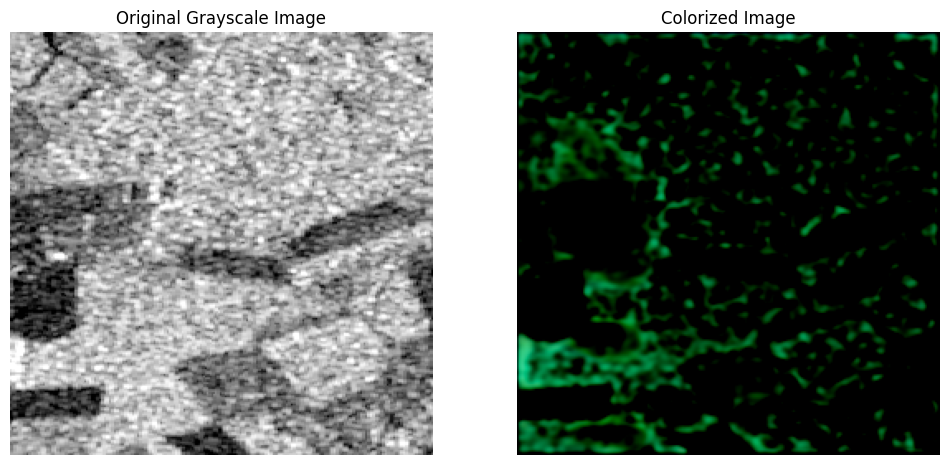

Image processing time: 1.44 seconds


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import time

# Load the pre-trained colorization model
model = load_model('/content/drive/MyDrive/generator_epoch_krish10.h5')

# Preprocess the input grayscale image
def preprocess_image(image_path):
    gray_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if gray_img is None:
        raise ValueError("Image not found or unable to load.")
    gray_img = gray_img / 255.0
    gray_img_resized = cv2.resize(gray_img, (256, 256))
    gray_img_resized = np.stack((gray_img_resized,) * 3, axis=-1)
    gray_img_resized = gray_img_resized.reshape(1, 256, 256, 3)
    return gray_img_resized

# Post-process the predicted colorized image
def postprocess_and_display(output, original_image_path):
    output = np.clip(output[0], 0, 1)
    output = (output * 255).astype(np.uint8)

    if output.shape[-1] != 3:
        raise ValueError("Output shape is not as expected. Check model output.")

    original_img = cv2.imread(original_image_path)
    if original_img is None:
        raise ValueError("Original image not found or unable to load.")
    original_img_resized = cv2.resize(original_img, (256, 256))
    output_resized = cv2.resize(output, (original_img_resized.shape[1], original_img_resized.shape[0]))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(cv2.cvtColor(original_img_resized, cv2.COLOR_BGR2GRAY), cmap='gray')
    ax[0].set_title('Original Grayscale Image')
    ax[0].axis('off')

    ax[1].imshow(cv2.cvtColor(output_resized, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Colorized Image')
    ax[1].axis('off')

    plt.show()

# Path to input image
input_image_path = '/content/ROIs1868_summer_s1_59_p2.png'

# Measure processing time
start_time = time.time()

# Preprocess the image
gray_img = preprocess_image(input_image_path)

# Predict colorized image
output = model.predict(gray_img)

# Postprocess and display the result
postprocess_and_display(output, input_image_path)

# Calculate and print processing time
end_time = time.time()
processing_time = end_time - start_time
print(f"Image processing time: {processing_time:.2f} seconds")


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
from tensorflow.keras import mixed_precision
from tqdm import tqdm

def attention_gate(x, g, inter_channel):
    theta_x = layers.Conv2D(inter_channel, 1, use_bias=False)(x)
    phi_g = layers.Conv2D(inter_channel, 1, use_bias=False)(g)
    f = layers.Activation('relu')(layers.add([theta_x, phi_g]))
    psi_f = layers.Conv2D(1, 1, use_bias=False)(f)
    rate = layers.Activation('sigmoid')(psi_f)
    att_x = layers.multiply([x, rate])
    return att_x

def residual_block(x, filters):
    res = layers.Conv2D(filters, 3, padding='same')(x)
    res = layers.BatchNormalization()(res)
    res = layers.ReLU()(res)
    res = layers.Conv2D(filters, 3, padding='same')(res)
    res = layers.BatchNormalization()(res)
    res = layers.Add()([res, x])
    return res

def build_generator(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    e1 = layers.Conv2D(64, 3, padding='same')(inputs)
    e1 = layers.LeakyReLU(alpha=0.2)(e1)
    e2 = layers.Conv2D(128, 3, strides=2, padding='same')(e1)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.LeakyReLU(alpha=0.2)(e2)
    e3 = layers.Conv2D(256, 3, strides=2, padding='same')(e2)
    e3 = layers.BatchNormalization()(e3)
    e3 = layers.LeakyReLU(alpha=0.2)(e3)
    e4 = layers.Conv2D(512, 3, strides=2, padding='same')(e3)
    e4 = layers.BatchNormalization()(e4)
    e4 = layers.LeakyReLU(alpha=0.2)(e4)

    # Bridge
    b = residual_block(e4, 512)
    b = residual_block(b, 512)
    b = residual_block(b, 512)

    # Decoder with Attention Gates
    d3 = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(b)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.ReLU()(d3)
    d3 = attention_gate(e3, d3, 128)
    d3 = layers.Concatenate()([d3, e3])

    d2 = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(d3)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.ReLU()(d2)
    d2 = attention_gate(e2, d2, 64)
    d2 = layers.Concatenate()([d2, e2])

    d1 = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(d2)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.ReLU()(d1)
    d1 = attention_gate(e1, d1, 32)
    d1 = layers.Concatenate()([d1, e1])

    outputs = layers.Conv2D(3, 3, activation='tanh', padding='same')(d1)

    return models.Model(inputs=inputs, outputs=outputs)

def build_discriminator(input_shape):
    def d_block(x, filters, strides=2, bn=True):
        x = layers.Conv2D(filters, 4, strides=strides, padding='same')(x)
        if bn:
            x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        return x

    inputs = layers.Input(input_shape)
    x = d_block(inputs, 64, bn=False)
    x = d_block(x, 128)
    x = d_block(x, 256)
    x = d_block(x, 512, strides=1)
    x = layers.Conv2D(1, 4, padding='same')(x)

    return models.Model(inputs=inputs, outputs=x)

class SARColorizer(models.Model):
    def __init__(self, input_shape):
        super(SARColorizer, self).__init__()
        self.generator = build_generator(input_shape)
        self.discriminator = build_discriminator((input_shape[0], input_shape[1], input_shape[2] + 3))
        self.vgg = self.build_vgg()

    def build_vgg(self):
        vgg = VGG19(weights='imagenet', include_top=False)
        return models.Model(inputs=vgg.inputs, outputs=vgg.get_layer('block3_conv3').output)

    def compile(self, g_optimizer, d_optimizer):
        super(SARColorizer, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def gradient_penalty(self, real, fake):
        alpha = tf.random.uniform([real.shape[0], 1, 1, 1], 0.0, 1.0)
        diff = fake - real
        interpolated = real + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    @tf.function
    def train_step(self, real_sar, real_optical):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generator
            fake_optical = self.generator(real_sar, training=True)

            # Discriminator
            real_combined = tf.concat([real_sar, real_optical], axis=-1)
            fake_combined = tf.concat([real_sar, fake_optical], axis=-1)

            real_output = self.discriminator(real_combined, training=True)
            fake_output = self.discriminator(fake_combined, training=True)

            # Losses
            gen_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)
            disc_loss = self.loss_fn(tf.ones_like(real_output), real_output) + \
                        self.loss_fn(tf.zeros_like(fake_output), fake_output)

            # Perceptual loss
            real_features = self.vgg(real_optical)
            fake_features = self.vgg(fake_optical)
            perceptual_loss = tf.reduce_mean(tf.square(real_features - fake_features))

            # L1 loss
            l1_loss = tf.reduce_mean(tf.abs(real_optical - fake_optical))

            # Total generator loss
            total_gen_loss = gen_loss + 100 * l1_loss + 0.1 * perceptual_loss

            # Gradient penalty
            gp = self.gradient_penalty(real_combined, fake_combined)
            total_disc_loss = disc_loss + 10 * gp

        # Compute gradients
        gen_gradients = gen_tape.gradient(total_gen_loss, self.generator.trainable_variables)
        disc_gradients = disc_tape.gradient(total_disc_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        return {"gen_loss": total_gen_loss, "disc_loss": total_disc_loss}

    def train(self, dataset, epochs):
        gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

        # Ensure optimizers use mixed precision
        gen_optimizer = mixed_precision.LossScaleOptimizer(gen_optimizer)
        disc_optimizer = mixed_precision.LossScaleOptimizer(disc_optimizer)

        vgg = VGG19(weights='imagenet', include_top=False)
        vgg.trainable = False

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            pbar = tqdm(total=len(dataset), unit='batch')
            for step, (sar_batch, optical_batch) in enumerate(dataset):
                total_gen_loss, disc_loss = self.train_step(sar_batch, optical_batch)
                pbar.update(1)
                pbar.set_description(f"Gen Loss: {total_gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")

            pbar.close()

            # Save the model every 5 epochs
            if (epoch + 1) % 5 == 0:
                self.generator.save(f'/content/drive/MyDrive/generator_epoch_krish{epoch+1}.h5')


In [ ]:

def main():
    base_dirs = [
        '/content/drive/MyDrive/SIH2024_Dataset/v_2/agri',
        '/content/drive/MyDrive/SIH2024_Dataset/v_2/barrenland',
        '/content/drive/MyDrive/SIH2024_Dataset/v_2/grassland',
        '/content/drive/MyDrive/SIH2024_Dataset/v_2/urban'
    ]

    # Create TensorFlow dataset
    dataset = create_dataset(base_dirs, max_images_per_folder=500, batch_size=8)

    # Define models
    generator = build_generator((256, 256, 3))
    discriminator = build_discriminator((256, 256, 6))  # Concatenated input shape

    # Train the model
    train(dataset, epochs=20, generator=generator, discriminator=discriminator)

if __name__ == "__main__":
    main()

Epoch 1/20



  0%|          | 0/250 [00:00<?, ?batch/s]

NameError: name 'train_step' is not defined